In [1]:
# Install required packages
!pip install gdown tqdm matplotlib pillow einops

In [2]:

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from einops import rearrange, repeat
import math
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
import zipfile
import shutil
import glob
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts


In [3]:

# -------------------------
# Squeeze and Excitation Block
# -------------------------
class SqueezeExcitation(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SqueezeExcitation, self).__init__()
        # Ensure reduction doesn't make channels too small
        reduction_channels = max(2, channel // reduction)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, reduction_channels, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(reduction_channels, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze
        y = self.avg_pool(x).view(b, c)
        # Excitation
        y = self.fc(y).view(b, c, 1, 1)
        # Scale
        return x * y.expand_as(x)

# -------------------------
# Dataset Download and Setup - Adapted for Kaggle
# -------------------------
def download_and_setup_dataset(force_download=False):
    """Download and properly set up Kvasir-SEG dataset"""
    base_path = '/kaggle/working/datasets'
    kvasir_path = os.path.join(base_path, 'kvasir-seg')
    
    # First check if dataset exists in Kaggle input directory
    kaggle_input_path = '/kaggle/input'
    for dirname, _, _ in os.walk(kaggle_input_path):
        if 'kvasir-seg' in dirname.lower() and os.path.exists(os.path.join(dirname, 'images')):
            print(f"Found Kvasir-SEG dataset at {dirname}")
            return dirname

    # Make sure base directory exists
    os.makedirs(base_path, exist_ok=True)

    # Check if dataset already exists in the expected directory structure
    if os.path.exists(os.path.join(kvasir_path, 'images')) and \
       os.path.exists(os.path.join(kvasir_path, 'masks')) and \
       len(os.listdir(os.path.join(kvasir_path, 'images'))) > 0 and \
       not force_download:
        print("Kvasir-SEG dataset already exists.")
        return kvasir_path

    # Direct URL to the zip file
    dataset_url = "https://datasets.simula.no/downloads/kvasir-seg.zip"
    zip_path = os.path.join(base_path, 'kvasir-seg.zip')

    # Download the dataset
    print("Downloading Kvasir-SEG dataset...")
    try:
        response = requests.get(dataset_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)

        with open(zip_path, 'wb') as f:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        return None

    print(f"Download completed, file saved to {zip_path}")

    # Extract the dataset
    print("Extracting dataset...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(base_path)
        print("Extraction completed.")
    except Exception as e:
        print(f"Error extracting dataset: {e}")
        return None

    # Check the structure of extracted files
    extracted_files = glob.glob(os.path.join(base_path, "**"), recursive=True)
    print("Extracted file structure:")
    for file in extracted_files[:10]:  # Show only first 10 files
        print(f"  {file}")
    if len(extracted_files) > 10:
        print(f"  ... and {len(extracted_files)-10} more files")

    # Locate the images and masks directories
    image_dirs = glob.glob(os.path.join(base_path, "**/images"), recursive=True)
    mask_dirs = glob.glob(os.path.join(base_path, "**/masks"), recursive=True)

    print(f"Found image directories: {image_dirs}")
    print(f"Found mask directories: {mask_dirs}")

    # Ensure proper directory structure
    os.makedirs(os.path.join(kvasir_path, 'images'), exist_ok=True)
    os.makedirs(os.path.join(kvasir_path, 'masks'), exist_ok=True)

    # Copy files to the expected location if needed
    if image_dirs and mask_dirs:
        src_image_dir = image_dirs[0]
        src_mask_dir = mask_dirs[0]

        if src_image_dir != os.path.join(kvasir_path, 'images'):
            print(f"Moving images from {src_image_dir} to {os.path.join(kvasir_path, 'images')}")
            for img_file in os.listdir(src_image_dir):
                shutil.copy(
                    os.path.join(src_image_dir, img_file),
                    os.path.join(kvasir_path, 'images', img_file)
                )

        if src_mask_dir != os.path.join(kvasir_path, 'masks'):
            print(f"Moving masks from {src_mask_dir} to {os.path.join(kvasir_path, 'masks')}")
            for mask_file in os.listdir(src_mask_dir):
                shutil.copy(
                    os.path.join(src_mask_dir, mask_file),
                    os.path.join(kvasir_path, 'masks', mask_file)
                )

    # Clean up
    try:
        os.remove(zip_path)
        print("Removed zip file.")
    except:
        print("Could not remove zip file.")

    # Verify the dataset is now properly set up
    if os.path.exists(os.path.join(kvasir_path, 'images')) and \
       os.path.exists(os.path.join(kvasir_path, 'masks')) and \
       len(os.listdir(os.path.join(kvasir_path, 'images'))) > 0:
        print("Dataset setup completed successfully.")
        print(f"Found {len(os.listdir(os.path.join(kvasir_path, 'images')))} images and "
              f"{len(os.listdir(os.path.join(kvasir_path, 'masks')))} masks.")
        return kvasir_path
    else:
        print("Dataset setup failed.")
        return None

# -------------------------
# Dataset class - No changes
# -------------------------
class KvasirSEGDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, target_transform=None, augment=True):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.augment = augment and split == 'train'  # Only augment training data
        self.img_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')

        # Verify directories exist
        if not os.path.exists(self.img_dir):
            raise ValueError(f"Images directory not found: {self.img_dir}")
        if not os.path.exists(self.mask_dir):
            raise ValueError(f"Masks directory not found: {self.mask_dir}")

        # Get all image files
        self.images = sorted([f for f in os.listdir(self.img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        if not self.images:
            raise ValueError(f"No images found in {self.img_dir}")

        # Print some sample image names for debugging
        print(f"Sample image names: {self.images[:5]}")

        # Split data into train/val/test (80/10/10 split)
        np.random.seed(42)  # For reproducibility
        indices = np.random.permutation(len(self.images))

        if split == 'train':
            self.images = [self.images[i] for i in indices[:int(0.8 * len(self.images))]]
        elif split == 'val':
            self.images = [self.images[i] for i in indices[int(0.8 * len(self.images)):int(0.9 * len(self.images))]]
        else:  # test
            self.images = [self.images[i] for i in indices[int(0.9 * len(self.images)):]]

        print(f"Created {split} dataset with {len(self.images)} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Find corresponding mask
        base_name = os.path.splitext(img_name)[0]
        mask_candidates = [
            os.path.join(self.mask_dir, base_name + ext)
            for ext in ['.jpg', '.png', '.jpeg', '.tif']
        ]
        mask_path = next((path for path in mask_candidates if os.path.exists(path)), None)

        if not mask_path:
            # Look for files that start with the same name
            mask_files = os.listdir(self.mask_dir)
            matches = [f for f in mask_files if f.startswith(base_name)]
            if matches:
                mask_path = os.path.join(self.mask_dir, matches[0])
            else:
                raise FileNotFoundError(f"No mask found for image {img_name}")

        # Print paths for debugging (only for the first item)
        if idx == 0:
            print(f"Image path: {img_path}")
            print(f"Mask path: {mask_path}")

        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Apply augmentation if enabled
        if self.augment:
            # Random horizontal flip
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)

            # Random vertical flip
            if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)

            # Random rotation
            if random.random() > 0.5:
                angle = random.choice([90, 180, 270])
                fill = 0
                image = TF.rotate(image, angle, fill=fill)
                mask = TF.rotate(mask, angle, fill=fill)

            # Color jitter (only for image)
            if random.random() > 0.5:
                image = TF.adjust_brightness(image, random.uniform(0.8, 1.2))
                image = TF.adjust_contrast(image, random.uniform(0.8, 1.2))
                image = TF.adjust_saturation(image, random.uniform(0.8, 1.2))

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            mask = self.target_transform(mask)
        else:
            # Default transformation for masks
            mask_array = np.array(mask)
            mask_binary = (mask_array > 0).astype(np.int64)
            mask = torch.from_numpy(mask_binary).long()  # Explicit cast to long

        # For debugging: print data types and ranges (only for the first item)
        if idx == 0:
            print(f"Image shape: {image.shape}, dtype: {image.dtype}, range: [{image.min()}, {image.max()}]")
            print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}, range: [{mask.min()}, {mask.max()}]")

        # Ensure mask is 2D (H,W) not 3D (1,H,W)
        if mask.dim() == 3 and mask.size(0) == 1:
            mask = mask.squeeze(0)

        return image, mask

# -------------------------
# Enhanced Selective Scan - No changes
# -------------------------
def selective_scan(u, delta, A, B, C, D):
    # Add numerical stability measures
    A = torch.clamp(A, min=-5.0, max=5.0)

    dA = torch.einsum('bld,dn->bldn', delta, A)
    dB_u = torch.einsum('bld,bld,bln->bldn', delta, u, B)

    dA_cumsum = torch.cat([dA[:, 1:], torch.zeros_like(dA[:, :1])], dim=1)
    dA_cumsum = torch.flip(dA_cumsum, dims=[1])
    dA_cumsum = torch.cumsum(dA_cumsum, dim=1)
    dA_cumsum = torch.clamp(dA_cumsum, max=15.0)
    dA_cumsum = torch.exp(dA_cumsum)
    dA_cumsum = torch.flip(dA_cumsum, dims=[1])

    x = dB_u * dA_cumsum
    x = torch.cumsum(x, dim=1) / (dA_cumsum + 1e-6)

    y = torch.einsum('bldn,bln->bld', x, C)
    return y + u * D

# -------------------------
# Combined Loss Function - No changes
# -------------------------
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        # BCE Loss
        bce = self.bce_loss(inputs, targets)

        # Dice Loss
        inputs_soft = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        # Calculate Dice loss manually
        intersection = (inputs_soft * targets_one_hot).sum(dim=(2, 3))
        cardinality = inputs_soft.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))

        dice = (2. * intersection / (cardinality + 1e-6)).mean()
        dice_loss = 1 - dice

        # Combined loss
        return self.bce_weight * bce + self.dice_weight * dice_loss

# -------------------------
# Improved MambaBlock - No changes
# -------------------------
class MambaBlock(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.in_proj = nn.Linear(args.model_input_dims, args.model_internal_dim * 2, bias=False)
        self.conv1d = nn.Conv1d(args.model_internal_dim, args.model_internal_dim, kernel_size=args.conv_kernel_size,
                               padding=args.conv_kernel_size-1, groups=args.model_internal_dim)
        self.x_proj = nn.Linear(args.model_internal_dim, args.delta_t_rank + args.model_states * 2, bias=False)
        self.delta_proj = nn.Linear(args.delta_t_rank, args.model_internal_dim)

        # Initialize A values
        A_vals = torch.arange(1, args.model_states + 1).float() / args.model_states * 3
        self.A_log = nn.Parameter(torch.log(repeat(A_vals, 'n -> d n', d=args.model_internal_dim)))
        self.D = nn.Parameter(torch.ones(args.model_internal_dim))
        self.out_proj = nn.Linear(args.model_internal_dim, args.model_input_dims, bias=args.dense_use_bias)

    def forward(self, x):
        # Use gradient checkpointing for better memory efficiency during training
        if self.training:
            return torch.utils.checkpoint.checkpoint(self._forward, x, use_reentrant=False)
        else:
            return self._forward(x)

    def _forward(self, x):
        b, l, d = x.shape
        x_and_res = self.in_proj(x)
        x1, res = x_and_res.chunk(2, dim=-1)

        x1 = rearrange(x1, 'b l d -> b d l')
        x1 = self.conv1d(x1)[..., :l]
        x1 = rearrange(x1, 'b d l -> b l d')
        x1 = F.silu(x1)

        # Apply bounded values for more stability
        A = -torch.exp(torch.clamp(self.A_log, min=-5, max=5))
        D = self.D
        x_dbl = self.x_proj(x1)
        delta, B, C = torch.split(x_dbl, [self.args.delta_t_rank, self.args.model_states, self.args.model_states], dim=-1)
        delta = F.softplus(self.delta_proj(delta))

        y = selective_scan(x1, delta, A, B, C, D)
        y = y * F.silu(res)
        return self.out_proj(y)

# -------------------------
# Enhanced Residual Block - No changes
# -------------------------
class ResidualBlock(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.norm1 = nn.LayerNorm(args.model_input_dims)
        self.mixer = MambaBlock(args)
        self.dropout = nn.Dropout(args.dropout_rate)
        self.norm2 = nn.LayerNorm(args.model_input_dims)

    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x = self.mixer(x)
        x = self.dropout(x)
        x = residual + x
        return self.norm2(x)

# -------------------------
# Double Convolution with SE
# -------------------------
class DoubleConvWithSE(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.same_channels = in_channels == out_channels
        
        # Double convolution
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        # Squeeze and Excitation block
        self.se = SqueezeExcitation(out_channels, reduction=8)
        
        # Optional projection for residual connection
        if not self.same_channels:
            self.project = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
            
    def forward(self, x):
        identity = x if self.same_channels else self.project(x)
        
        # Double convolution
        x = self.double_conv(x)
        
        # Apply SE attention
        x = self.se(x)
        
        # Residual connection
        x = x + identity
        
        return x

# -------------------------
# Improved Model Args - No changes
# -------------------------
class ModelArgs:
    def __init__(self):
        # Model dimensions
        self.model_input_dims = 96
        self.model_states = 96
        self.projection_expand_factor = 2
        self.conv_kernel_size = 4
        self.conv_use_bias = False
        self.dense_use_bias = False
        self.layer_id = -1
        self.seq_length = 256
        self.num_layers = 4
        self.dropout_rate = 0.2
        self.use_lm_head = False
        self.num_classes = 2  # Binary segmentation
        self.final_activation = 'none'
        self.model_internal_dim = self.projection_expand_factor * self.model_input_dims
        self.delta_t_rank = math.ceil(self.model_input_dims / 16)

# -------------------------
# Mamba-UNet with SE Attention Only (No Fusion)
# -------------------------
class MambaUNetWithSE(nn.Module):
    def __init__(self, args):
        super().__init__()

        # Encoder path with SE attention
        self.encoder1 = DoubleConvWithSE(3, 64)  # Input: 3 RGB channels
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = DoubleConvWithSE(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.encoder3 = DoubleConvWithSE(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        # Mamba blocks in the bottleneck
        self.mamba_blocks = nn.Sequential(*[ResidualBlock(args) for _ in range(args.num_layers)])

        # Bridge between CNN and Mamba
        self.bridge_down = nn.Conv2d(256, args.model_input_dims, kernel_size=1)
        self.bridge_up = nn.Conv2d(args.model_input_dims, 256, kernel_size=1)
        
        # SE block for bottleneck features
        self.bottleneck_se = SqueezeExcitation(256, reduction=16)

        # Decoder path with skip connections
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = DoubleConvWithSE(256, 128)  # 256 = 128 (upconv) + 128 (skip)
        self.deep_sup3 = nn.Conv2d(128, args.num_classes, kernel_size=1)
        self.se3 = SqueezeExcitation(128, reduction=8)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = DoubleConvWithSE(128, 64)  # 128 = 64 (upconv) + 64 (skip)
        self.deep_sup2 = nn.Conv2d(64, args.num_classes, kernel_size=1)
        self.se2 = SqueezeExcitation(64, reduction=8)

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = DoubleConvWithSE(35, 32)  # 35 = 32 (upconv) + 3 (original input)
        self.se1 = SqueezeExcitation(32, reduction=4)

        # Final layer
        self.final_conv = nn.Conv2d(32, args.num_classes, kernel_size=1)
        
        # Output SE module
        self.output_se = SqueezeExcitation(args.num_classes, reduction=2)

    def forward(self, x, return_deep=False):
        # Save input for skip connection
        input_x = x
        
        # Encoder path
        enc1 = self.encoder1(x)      # 64 channels
        enc1_pool = self.pool1(enc1)

        enc2 = self.encoder2(enc1_pool)  # 128 channels
        enc2_pool = self.pool2(enc2)

        enc3 = self.encoder3(enc2_pool)  # 256 channels
        enc3_pool = self.pool3(enc3)

        # Bridge to Mamba
        bridge_out = self.bridge_down(enc3_pool)

        # Reshape for Mamba blocks
        b, c, h, w = bridge_out.size()
        mamba_input = bridge_out.permute(0, 2, 3, 1).reshape(b, h * w, c)

        # Apply Mamba blocks
        mamba_output = self.mamba_blocks(mamba_input)

        # Reshape back to 2D
        mamba_output = mamba_output.reshape(b, h, w, c).permute(0, 3, 1, 2)

        # Bridge back to CNN
        mamba_output = self.bridge_up(mamba_output)
        
        # Apply SE to bottleneck features
        mamba_output = self.bottleneck_se(mamba_output)

        # Decoder path with skip connections
        dec3 = self.upconv3(mamba_output)
        if dec3.shape[2:] != enc2.shape[2:]:
            dec3 = F.interpolate(dec3, size=enc2.shape[2:], mode='bilinear', align_corners=True)
        
        # Concatenate and process
        dec3 = torch.cat([dec3, enc2], dim=1)
        dec3 = self.decoder3(dec3)
        dec3 = self.se3(dec3)  # Apply SE attention
        deep_out3 = self.deep_sup3(dec3)

        dec2 = self.upconv2(dec3)
        if dec2.shape[2:] != enc1.shape[2:]:
            dec2 = F.interpolate(dec2, size=enc1.shape[2:], mode='bilinear', align_corners=True)
        
        # Concatenate and process
        dec2 = torch.cat([dec2, enc1], dim=1)
        dec2 = self.decoder2(dec2)
        dec2 = self.se2(dec2)  # Apply SE attention
        deep_out2 = self.deep_sup2(dec2)

        dec1 = self.upconv1(dec2)
        if dec1.shape[2:] != input_x.shape[2:]:
            dec1 = F.interpolate(dec1, size=input_x.shape[2:], mode='bilinear', align_corners=True)
        
        # Concatenate and process
        dec1 = torch.cat([dec1, input_x], dim=1)  # Skip connection to original input
        dec1 = self.decoder1(dec1)
        dec1 = self.se1(dec1)  # Apply SE attention

        # Final layer with SE attention
        out = self.final_conv(dec1)
        out = self.output_se(out)  # Output SE attention

        if return_deep:
            # Return main output and deep supervision outputs
            deep_out2 = F.interpolate(deep_out2, size=input_x.shape[2:], mode='bilinear', align_corners=True)
            deep_out3 = F.interpolate(deep_out3, size=input_x.shape[2:], mode='bilinear', align_corners=True)
            return out, deep_out2, deep_out3

        return out

# -------------------------
# Deep Supervision Loss - No changes
# -------------------------
class DeepSupervisionLoss(nn.Module):
    def __init__(self, main_weight=0.6, deep2_weight=0.2, deep3_weight=0.2):
        super(DeepSupervisionLoss, self).__init__()
        self.main_weight = main_weight
        self.deep2_weight = deep2_weight
        self.deep3_weight = deep3_weight
        self.criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)

    def forward(self, outputs, target):
        main_out, deep2, deep3 = outputs

        loss_main = self.criterion(main_out, target)
        loss_deep2 = self.criterion(deep2, target)
        loss_deep3 = self.criterion(deep3, target)

        total_loss = (
            self.main_weight * loss_main +
            self.deep2_weight * loss_deep2 +
            self.deep3_weight * loss_deep3
        )

        return total_loss

# -------------------------
# Evaluation Metrics - No changes
# -------------------------
def calculate_iou(pred_mask, gt_mask):
    """Calculate IoU for binary segmentation"""
    pred_mask = (pred_mask > 0).cpu().numpy().astype(bool)
    gt_mask = (gt_mask > 0).cpu().numpy().astype(bool)

    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()

    if union == 0:
        return 1.0  # If both masks are empty, IoU is 1

    return intersection / union

def calculate_dice(pred_mask, gt_mask):
    """Calculate Dice coefficient"""
    pred_mask = (pred_mask > 0).cpu().numpy().astype(bool)
    gt_mask = (gt_mask > 0).cpu().numpy().astype(bool)

    intersection = np.logical_and(pred_mask, gt_mask).sum()
    sum_areas = pred_mask.sum() + gt_mask.sum()

    if sum_areas == 0:
        return 1.0  # If both masks are empty, Dice is 1

    return 2.0 * intersection / sum_areas

# -------------------------
# Plot training progress - Adapted for Kaggle
# -------------------------
def plot_training_progress(history, epoch):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history['train_iou'], label='Train IoU')
    plt.plot(history['val_iou'], label='Val IoU')
    plt.title('IoU')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history['train_dice'], label='Train Dice')
    plt.plot(history['val_dice'], label='Val Dice')
    plt.title('Dice')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"/kaggle/working/training_progress_epoch_{epoch}.png")
    plt.close()

# -------------------------
# Enhanced Training Function - No changes
# -------------------------
def train_one_epoch_enhanced(model, dataloader, optimizer, criterion, device, scheduler=None):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_dice = 0.0
    sample_count = 0

    pbar = tqdm(dataloader, desc='Training')

    for i, (images, masks) in enumerate(pbar):
        # Move data to device
        images = images.to(device)
        masks = masks.to(device)

        # Check data shape for the first batch
        if i == 0:
            print(f"Training batch - Images: {images.shape}, Masks: {masks.shape}")
            print(f"Masks unique values: {torch.unique(masks)}")

        # Forward pass with deep supervision
        outputs = model(images, return_deep=True)

        # Calculate loss with deep supervision
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        # Optional gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Step scheduler if provided
        if scheduler is not None:
            scheduler.step()

        # Get main output for metrics calculation
        main_output = outputs[0]

        # Calculate metrics
        batch_size = images.size(0)
        preds = torch.argmax(main_output, dim=1)

        # Update statistics
        running_loss += loss.item() * batch_size

        # Calculate metrics per image
        batch_iou = 0
        batch_dice = 0
        for j in range(batch_size):
            iou = calculate_iou(preds[j], masks[j])
            dice = calculate_dice(preds[j], masks[j])
            batch_iou += iou
            batch_dice += dice

        running_iou += batch_iou
        running_dice += batch_dice
        sample_count += batch_size

        # Update progress bar
        pbar.set_postfix({
            'loss': loss.item(),
            'iou': batch_iou / batch_size,
            'dice': batch_dice / batch_size
        })

        # Clear some GPU memory if needed
        del outputs, loss, preds
        if i % 10 == 0 and torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Calculate epoch statistics
    epoch_loss = running_loss / sample_count
    epoch_iou = running_iou / sample_count
    epoch_dice = running_dice / sample_count

    return epoch_loss, epoch_iou, epoch_dice

# -------------------------
# Validation Function - No changes
# -------------------------
def validate_enhanced(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    running_dice = 0.0
    sample_count = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc='Validation'):
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass with deep supervision
            outputs = model(images, return_deep=True)

            # Calculate loss with deep supervision
            loss = criterion(outputs, masks)

            # Get main output for metrics calculation
            main_output = outputs[0]

            # Calculate metrics
            batch_size = images.size(0)
            preds = torch.argmax(main_output, dim=1)

            # Update statistics
            running_loss += loss.item() * batch_size

            # Calculate metrics per image
            for j in range(batch_size):
                iou = calculate_iou(preds[j], masks[j])
                dice = calculate_dice(preds[j], masks[j])
                running_iou += iou
                running_dice += dice

            sample_count += batch_size

    # Calculate statistics
    val_loss = running_loss / sample_count
    val_iou = running_iou / sample_count
    val_dice = running_dice / sample_count

    return val_loss, val_iou, val_dice

# -------------------------
# Visualization Function - Adapted for Kaggle
# -------------------------
def visualize_results(model, dataloader, device, num_samples=3):
    model.eval()

    # Get a batch of data
    images, masks = next(iter(dataloader))
    images = images[:num_samples].to(device)
    masks = masks[:num_samples].to(device)

    # Generate predictions
    with torch.no_grad():
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)

    # Denormalize images for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    images = images * std + mean

    # Create figure with subplots
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        # Display original image
        axes[i, 0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        # Display ground truth mask
        axes[i, 1].imshow(masks[i].cpu().numpy(), cmap="gray")
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")

        # Display predicted mask
        axes[i, 2].imshow(predictions[i].cpu().numpy(), cmap="gray")
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.savefig("/kaggle/working/mamba_segmentation_with_se_results.png")
    plt.show()



Starting Mamba-UNet with Squeeze-Excitation Attention (No Feature Fusion)...
Using device: cuda


100%|██████████| 46.2M/46.2M [00:02<00:00, 19.2MiB/s]


Download completed, file saved to /kaggle/working/datasets/kvasir-seg.zip
Extracting dataset...
Extraction completed.
Extracted file structure:
  /kaggle/working/datasets/
  /kaggle/working/datasets/kvasir-seg.zip
  /kaggle/working/datasets/Kvasir-SEG
  /kaggle/working/datasets/Kvasir-SEG/images
  /kaggle/working/datasets/Kvasir-SEG/images/cju5v8pgplg6k0755rvi2t63h.jpg
  /kaggle/working/datasets/Kvasir-SEG/images/cju303j5r062k098835zxfds5.jpg
  /kaggle/working/datasets/Kvasir-SEG/images/cju5ygh1zmmdi0755uod5e17i.jpg
  /kaggle/working/datasets/Kvasir-SEG/images/cju6vvb8svhed0801jjcquh5e.jpg
  /kaggle/working/datasets/Kvasir-SEG/images/cju3yb47cj1xq0817zfotbni4.jpg
  /kaggle/working/datasets/Kvasir-SEG/images/cju2urqpwvxw70835rvndvtsi.jpg
  ... and 1996 more files
Found image directories: ['/kaggle/working/datasets/Kvasir-SEG/images']
Found mask directories: ['/kaggle/working/datasets/Kvasir-SEG/masks']
Moving images from /kaggle/working/datasets/Kvasir-SEG/images to /kaggle/working/data

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  83%|████████▎ | 166/200 [02:20<00:28,  1.18it/s, loss=0.494, iou=0.237, dice=0.351] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.032280206680298, 2.0648367404937744]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.5394, IoU: 0.2422, Dice: 0.3525
Val   - Loss: 0.4635, IoU: 0.2033, Dice: 0.2961
Model saved with IoU: 0.2033
Epoch 2/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  38%|███▊      | 75/200 [01:03<01:45,  1.18it/s, loss=0.397, iou=0.263, dice=0.38] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.3775, IoU: 0.3268, Dice: 0.4511
Val   - Loss: 0.3639, IoU: 0.2451, Dice: 0.3482
Model saved with IoU: 0.2451
Epoch 3/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  85%|████████▌ | 170/200 [02:23<00:25,  1.19it/s, loss=0.422, iou=0.173, dice=0.281]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9809060096740723, 2.1519827842712402]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s]


Train - Loss: 0.3201, IoU: 0.3568, Dice: 0.4814
Val   - Loss: 0.3344, IoU: 0.3192, Dice: 0.4354
Model saved with IoU: 0.3192
Epoch 4/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  49%|████▉     | 98/200 [01:22<01:25,  1.19it/s, loss=0.368, iou=0.226, dice=0.334] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.3227, IoU: 0.3581, Dice: 0.4823
Val   - Loss: 0.3350, IoU: 0.3154, Dice: 0.4323
Epoch 5/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  40%|████      | 81/200 [01:08<01:41,  1.17it/s, loss=0.197, iou=0.539, dice=0.683]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6051416397094727]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.3017, IoU: 0.3957, Dice: 0.5245
Val   - Loss: 0.3585, IoU: 0.2310, Dice: 0.3182
Epoch 6/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  16%|█▋        | 33/200 [00:28<02:21,  1.18it/s, loss=0.202, iou=0.552, dice=0.675]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.2910, IoU: 0.4105, Dice: 0.5357
Val   - Loss: 0.3055, IoU: 0.3754, Dice: 0.4972
Model saved with IoU: 0.3754
Epoch 7/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  10%|█         | 20/200 [00:17<02:31,  1.19it/s, loss=0.198, iou=0.576, dice=0.723]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.2900, IoU: 0.4191, Dice: 0.5437
Val   - Loss: 0.3417, IoU: 0.2764, Dice: 0.3727
Epoch 8/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  72%|███████▏  | 144/200 [02:01<00:47,  1.18it/s, loss=0.317, iou=0.349, dice=0.51] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6051416397094727]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.2965, IoU: 0.4134, Dice: 0.5368
Val   - Loss: 0.3161, IoU: 0.3518, Dice: 0.4713
Epoch 9/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  84%|████████▍ | 168/200 [02:22<00:26,  1.19it/s, loss=0.585, iou=0.482, dice=0.593]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.3785624504089355]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.2865, IoU: 0.4262, Dice: 0.5514
Val   - Loss: 0.3084, IoU: 0.3386, Dice: 0.4453
Epoch 10/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  26%|██▋       | 53/200 [00:44<02:04,  1.18it/s, loss=0.34, iou=0.323, dice=0.476] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1007792949676514, 2.5702831745147705]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.2754, IoU: 0.4456, Dice: 0.5698
Val   - Loss: 0.2804, IoU: 0.4291, Dice: 0.5474
Model saved with IoU: 0.4291
Epoch 11/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  10%|█         | 21/200 [00:17<02:32,  1.17it/s, loss=0.149, iou=0.602, dice=0.735]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.2585, IoU: 0.4815, Dice: 0.6063
Val   - Loss: 0.2738, IoU: 0.4449, Dice: 0.5603
Model saved with IoU: 0.4449
Epoch 12/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  18%|█▊        | 36/200 [00:30<02:18,  1.18it/s, loss=0.301, iou=0.448, dice=0.548]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9124069213867188, 2.047407627105713]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.2535, IoU: 0.4933, Dice: 0.6166
Val   - Loss: 0.2660, IoU: 0.4571, Dice: 0.5730
Model saved with IoU: 0.4571
Epoch 13/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  24%|██▍       | 49/200 [00:41<02:07,  1.19it/s, loss=0.283, iou=0.451, dice=0.556]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.2481, IoU: 0.5036, Dice: 0.6270
Val   - Loss: 0.2982, IoU: 0.4193, Dice: 0.5440
Epoch 14/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  88%|████████▊ | 177/200 [02:29<00:19,  1.18it/s, loss=0.376, iou=0.415, dice=0.558]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1007792949676514, 2.5005664825439453]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.2735, IoU: 0.4510, Dice: 0.5766
Val   - Loss: 0.2794, IoU: 0.4523, Dice: 0.5705
Epoch 15/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  49%|████▉     | 98/200 [01:22<01:25,  1.19it/s, loss=0.152, iou=0.526, dice=0.6]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.2646, IoU: 0.4711, Dice: 0.5961
Val   - Loss: 0.2789, IoU: 0.4164, Dice: 0.5375
Epoch 16/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  80%|████████  | 161/200 [02:16<00:33,  1.17it/s, loss=0.285, iou=0.416, dice=0.532]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9466564655303955, 1.9776908159255981]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.2652, IoU: 0.4760, Dice: 0.5990
Val   - Loss: 0.2809, IoU: 0.4121, Dice: 0.5296
Epoch 17/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  62%|██████▎   | 125/200 [01:45<01:03,  1.18it/s, loss=0.22, iou=0.562, dice=0.715]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.998030662536621, 2.4482791423797607]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.2501, IoU: 0.5095, Dice: 0.6324
Val   - Loss: 0.2566, IoU: 0.4822, Dice: 0.6034
Model saved with IoU: 0.4822
Epoch 18/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  60%|█████▉    | 119/200 [01:40<01:08,  1.19it/s, loss=0.349, iou=0.392, dice=0.554]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9466564655303955, 1.4548150300979614]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.2405, IoU: 0.5254, Dice: 0.6453
Val   - Loss: 0.2512, IoU: 0.4910, Dice: 0.6115
Model saved with IoU: 0.4910
Epoch 19/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  67%|██████▋   | 134/200 [01:53<00:56,  1.18it/s, loss=0.189, iou=0.535, dice=0.69]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.55it/s]


Train - Loss: 0.2362, IoU: 0.5334, Dice: 0.6541
Val   - Loss: 0.2429, IoU: 0.5057, Dice: 0.6117
Model saved with IoU: 0.5057
Epoch 20/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:   2%|▎         | 5/200 [00:04<02:47,  1.16it/s, loss=0.265, iou=0.495, dice=0.651]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.2206, IoU: 0.5605, Dice: 0.6804
Val   - Loss: 0.2222, IoU: 0.5428, Dice: 0.6611
Model saved with IoU: 0.5428
Epoch 21/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  65%|██████▌   | 130/200 [01:50<00:59,  1.19it/s, loss=0.218, iou=0.503, dice=0.641] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.2177, IoU: 0.5676, Dice: 0.6856
Val   - Loss: 0.2284, IoU: 0.5385, Dice: 0.6549
Epoch 22/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  68%|██████▊   | 137/200 [01:56<00:53,  1.19it/s, loss=0.273, iou=0.628, dice=0.724]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.2099, IoU: 0.5866, Dice: 0.7016
Val   - Loss: 0.2158, IoU: 0.5575, Dice: 0.6734
Model saved with IoU: 0.5575
Epoch 23/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  70%|██████▉   | 139/200 [01:57<00:51,  1.19it/s, loss=0.219, iou=0.518, dice=0.665] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.60it/s]


Train - Loss: 0.2018, IoU: 0.5984, Dice: 0.7151
Val   - Loss: 0.2173, IoU: 0.5682, Dice: 0.6854
Model saved with IoU: 0.5682
Epoch 24/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  30%|███       | 61/200 [00:51<01:58,  1.17it/s, loss=0.4, iou=0.528, dice=0.658]   

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.1993, IoU: 0.6046, Dice: 0.7177
Val   - Loss: 0.2170, IoU: 0.5734, Dice: 0.6833
Model saved with IoU: 0.5734
Epoch 25/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  15%|█▌        | 30/200 [00:25<02:23,  1.19it/s, loss=0.259, iou=0.549, dice=0.703] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1007792949676514, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.1959, IoU: 0.6096, Dice: 0.7227
Val   - Loss: 0.2156, IoU: 0.5739, Dice: 0.6872
Model saved with IoU: 0.5739
Epoch 26/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  78%|███████▊  | 156/200 [02:12<00:37,  1.19it/s, loss=0.295, iou=0.396, dice=0.536] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.8267831802368164, 2.204270362854004]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.2100, IoU: 0.5808, Dice: 0.6981
Val   - Loss: 0.2615, IoU: 0.4867, Dice: 0.5931
Epoch 27/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  71%|███████   | 142/200 [02:00<00:49,  1.17it/s, loss=0.248, iou=0.4, dice=0.57]    

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.2307, IoU: 0.5473, Dice: 0.6688
Val   - Loss: 0.2471, IoU: 0.5220, Dice: 0.6449
Epoch 28/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  96%|█████████▋| 193/200 [02:43<00:05,  1.18it/s, loss=0.203, iou=0.581, dice=0.701] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6051416397094727]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.2303, IoU: 0.5503, Dice: 0.6696
Val   - Loss: 0.2279, IoU: 0.5374, Dice: 0.6593
Epoch 29/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  56%|█████▌    | 111/200 [01:34<01:15,  1.17it/s, loss=0.251, iou=0.492, dice=0.632]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.2188, IoU: 0.5652, Dice: 0.6830
Val   - Loss: 0.2375, IoU: 0.5385, Dice: 0.6487
Epoch 30/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  32%|███▏      | 63/200 [00:53<01:56,  1.18it/s, loss=0.164, iou=0.562, dice=0.716] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.2142, IoU: 0.5783, Dice: 0.6969
Val   - Loss: 0.2351, IoU: 0.5092, Dice: 0.6167
Epoch 31/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  64%|██████▎   | 127/200 [01:47<01:01,  1.19it/s, loss=0.135, iou=0.641, dice=0.769]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.56it/s]


Train - Loss: 0.2065, IoU: 0.5899, Dice: 0.7062
Val   - Loss: 0.2278, IoU: 0.5490, Dice: 0.6543
Epoch 32/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  40%|████      | 81/200 [01:08<01:41,  1.17it/s, loss=0.184, iou=0.642, dice=0.758] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.878157377243042, 2.3088455200195312]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.2007, IoU: 0.6055, Dice: 0.7204
Val   - Loss: 0.2200, IoU: 0.5671, Dice: 0.6795
Epoch 33/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  79%|███████▉  | 158/200 [02:13<00:35,  1.19it/s, loss=0.339, iou=0.497, dice=0.603] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1919, IoU: 0.6227, Dice: 0.7355
Val   - Loss: 0.2448, IoU: 0.5424, Dice: 0.6405
Epoch 34/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  26%|██▌       | 52/200 [00:44<02:06,  1.17it/s, loss=0.231, iou=0.493, dice=0.629] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6051416397094727]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1977, IoU: 0.6167, Dice: 0.7285
Val   - Loss: 0.2024, IoU: 0.6106, Dice: 0.7175
Model saved with IoU: 0.6106
Epoch 35/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  72%|███████▏  | 143/200 [02:01<00:48,  1.18it/s, loss=0.282, iou=0.491, dice=0.604] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1842, IoU: 0.6339, Dice: 0.7445
Val   - Loss: 0.2147, IoU: 0.5893, Dice: 0.6902
Epoch 36/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  46%|████▌     | 91/200 [01:17<01:33,  1.17it/s, loss=0.148, iou=0.672, dice=0.763] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.1811, IoU: 0.6445, Dice: 0.7529
Val   - Loss: 0.1909, IoU: 0.6196, Dice: 0.7288
Model saved with IoU: 0.6196
Epoch 37/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  69%|██████▉   | 138/200 [01:56<00:52,  1.19it/s, loss=0.279, iou=0.493, dice=0.651] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.7582842111587524, 2.117124319076538]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.1733, IoU: 0.6555, Dice: 0.7621
Val   - Loss: 0.1943, IoU: 0.6133, Dice: 0.7201
Epoch 38/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  70%|██████▉   | 139/200 [01:57<00:51,  1.19it/s, loss=0.136, iou=0.741, dice=0.845] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1742, IoU: 0.6578, Dice: 0.7636
Val   - Loss: 0.1900, IoU: 0.6339, Dice: 0.7369
Model saved with IoU: 0.6339
Epoch 39/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  80%|████████  | 161/200 [02:16<00:33,  1.17it/s, loss=0.175, iou=0.594, dice=0.73]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6051416397094727]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.1668, IoU: 0.6648, Dice: 0.7696
Val   - Loss: 0.1777, IoU: 0.6548, Dice: 0.7562
Model saved with IoU: 0.6548
Epoch 40/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  52%|█████▏    | 104/200 [01:28<01:21,  1.18it/s, loss=0.0894, iou=0.84, dice=0.909]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9809060096740723, 2.1345534324645996]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1625, IoU: 0.6765, Dice: 0.7779
Val   - Loss: 0.1861, IoU: 0.6292, Dice: 0.7349
Epoch 41/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  88%|████████▊ | 176/200 [02:29<00:20,  1.18it/s, loss=0.254, iou=0.501, dice=0.664] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9637812376022339, 1.7162529230117798]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.1580, IoU: 0.6787, Dice: 0.7813
Val   - Loss: 0.1794, IoU: 0.6477, Dice: 0.7495
Epoch 42/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  93%|█████████▎| 186/200 [02:37<00:11,  1.18it/s, loss=0.155, iou=0.683, dice=0.772] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1556, IoU: 0.6898, Dice: 0.7899
Val   - Loss: 0.1784, IoU: 0.6567, Dice: 0.7565
Model saved with IoU: 0.6567
Epoch 43/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')

Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1487, IoU: 0.7013, Dice: 0.7994
Val   - Loss: 0.1809, IoU: 0.6568, Dice: 0.7521
Model saved with IoU: 0.6568
Epoch 44/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  50%|████▉     | 99/200 [01:23<01:25,  1.19it/s, loss=0.168, iou=0.71, dice=0.811]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.1473, IoU: 0.7036, Dice: 0.8000
Val   - Loss: 0.1766, IoU: 0.6575, Dice: 0.7582
Model saved with IoU: 0.6575
Epoch 45/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  64%|██████▎   | 127/200 [01:47<01:01,  1.18it/s, loss=0.048, iou=0.867, dice=0.928] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.0494048595428467, 2.4134206771850586]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1398, IoU: 0.7177, Dice: 0.8135
Val   - Loss: 0.1824, IoU: 0.6551, Dice: 0.7494
Epoch 46/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  55%|█████▍    | 109/200 [01:32<01:16,  1.19it/s, loss=0.248, iou=0.721, dice=0.815] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.1345534324645996]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.1400, IoU: 0.7144, Dice: 0.8087
Val   - Loss: 0.1751, IoU: 0.6695, Dice: 0.7664
Model saved with IoU: 0.6695
Epoch 47/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  24%|██▎       | 47/200 [00:39<02:09,  1.19it/s, loss=0.0816, iou=0.75, dice=0.846] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9295316934585571, 2.3437039852142334]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.1382, IoU: 0.7174, Dice: 0.8115
Val   - Loss: 0.1732, IoU: 0.6688, Dice: 0.7649
Epoch 48/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  92%|█████████▏| 184/200 [02:35<00:13,  1.18it/s, loss=0.124, iou=0.606, dice=0.734] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6051416397094727]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1379, IoU: 0.7236, Dice: 0.8170
Val   - Loss: 0.1750, IoU: 0.6648, Dice: 0.7595
Epoch 49/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  62%|██████▏   | 123/200 [01:44<01:05,  1.18it/s, loss=0.216, iou=0.672, dice=0.775] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6051416397094727]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1359, IoU: 0.7271, Dice: 0.8186
Val   - Loss: 0.1726, IoU: 0.6690, Dice: 0.7655
Epoch 50/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:   2%|▎         | 5/200 [00:04<02:46,  1.17it/s, loss=0.062, iou=0.862, dice=0.924] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1327, IoU: 0.7279, Dice: 0.8207
Val   - Loss: 0.1709, IoU: 0.6737, Dice: 0.7692
Model saved with IoU: 0.6737
Epoch 51/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  46%|████▌     | 91/200 [01:17<01:32,  1.17it/s, loss=0.154, iou=0.683, dice=0.803] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.117124319076538]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.1329, IoU: 0.7269, Dice: 0.8205
Val   - Loss: 0.1739, IoU: 0.6701, Dice: 0.7657
Epoch 52/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  64%|██████▎   | 127/200 [01:47<01:01,  1.18it/s, loss=0.233, iou=0.426, dice=0.493] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.1738, IoU: 0.6588, Dice: 0.7608
Val   - Loss: 0.2037, IoU: 0.6122, Dice: 0.7198
Epoch 53/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  48%|████▊     | 96/200 [01:21<01:27,  1.19it/s, loss=0.0965, iou=0.823, dice=0.896]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.1736, IoU: 0.6645, Dice: 0.7677
Val   - Loss: 0.2079, IoU: 0.5985, Dice: 0.7059
Epoch 54/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  24%|██▍       | 49/200 [00:41<02:07,  1.19it/s, loss=0.134, iou=0.79, dice=0.88]   

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1705, IoU: 0.6634, Dice: 0.7657
Val   - Loss: 0.2034, IoU: 0.6096, Dice: 0.7205
Epoch 55/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  14%|█▍        | 28/200 [00:23<02:24,  1.19it/s, loss=0.224, iou=0.633, dice=0.72]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.1724, IoU: 0.6627, Dice: 0.7666
Val   - Loss: 0.1989, IoU: 0.6241, Dice: 0.7310
Epoch 56/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  40%|████      | 81/200 [01:08<01:41,  1.17it/s, loss=0.14, iou=0.776, dice=0.84]   

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1634, IoU: 0.6729, Dice: 0.7780
Val   - Loss: 0.1991, IoU: 0.6202, Dice: 0.7246
Epoch 57/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  34%|███▍      | 68/200 [00:57<01:51,  1.19it/s, loss=0.189, iou=0.76, dice=0.859]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.8952821493148804, 1.332810640335083]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.1634, IoU: 0.6740, Dice: 0.7756
Val   - Loss: 0.1866, IoU: 0.6357, Dice: 0.7328
Epoch 58/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  24%|██▍       | 49/200 [00:41<02:07,  1.19it/s, loss=0.241, iou=0.677, dice=0.795] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1613, IoU: 0.6732, Dice: 0.7765
Val   - Loss: 0.1898, IoU: 0.6263, Dice: 0.7220
Epoch 59/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  16%|█▋        | 33/200 [00:28<02:21,  1.18it/s, loss=0.103, iou=0.791, dice=0.862] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9124069213867188, 2.0648367404937744]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.1553, IoU: 0.6884, Dice: 0.7886
Val   - Loss: 0.1985, IoU: 0.6147, Dice: 0.7098
Epoch 60/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:   5%|▌         | 10/200 [00:08<02:40,  1.18it/s, loss=0.0753, iou=0.827, dice=0.904]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.8610327243804932, 1.9776908159255981]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.1570, IoU: 0.6871, Dice: 0.7853
Val   - Loss: 0.1891, IoU: 0.6416, Dice: 0.7379
Epoch 61/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  81%|████████  | 162/200 [02:17<00:32,  1.17it/s, loss=0.195, iou=0.695, dice=0.785] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.1541, IoU: 0.6952, Dice: 0.7932
Val   - Loss: 0.1710, IoU: 0.6583, Dice: 0.7543
Epoch 62/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  18%|█▊        | 37/200 [00:31<02:17,  1.19it/s, loss=0.112, iou=0.729, dice=0.826] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.8439079523086548, 2.0996952056884766]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.1487, IoU: 0.7011, Dice: 0.7980
Val   - Loss: 0.1789, IoU: 0.6519, Dice: 0.7471
Epoch 63/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]
Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1443, IoU: 0.7087, Dice: 0.8035
Val   - Loss: 0.1890, IoU: 0.6634, Dice: 0.7612
Epoch 64/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  67%|██████▋   | 134/200 [01:53<00:55,  1.18it/s, loss=0.13, iou=0.629, dice=0.751]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1474, IoU: 0.7109, Dice: 0.8068
Val   - Loss: 0.1631, IoU: 0.6715, Dice: 0.7708
Epoch 65/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  78%|███████▊  | 156/200 [02:12<00:37,  1.18it/s, loss=0.11, iou=0.852, dice=0.91]   

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1432, IoU: 0.7146, Dice: 0.8086
Val   - Loss: 0.1650, IoU: 0.6748, Dice: 0.7776
Model saved with IoU: 0.6748
Epoch 66/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  93%|█████████▎| 186/200 [02:37<00:11,  1.19it/s, loss=0.063, iou=0.861, dice=0.923] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 1.942832350730896]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.1435, IoU: 0.7141, Dice: 0.8071
Val   - Loss: 0.1800, IoU: 0.6521, Dice: 0.7580
Epoch 67/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  20%|██        | 40/200 [00:34<02:14,  1.19it/s, loss=0.235, iou=0.501, dice=0.617] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.1868410110473633]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.1348, IoU: 0.7272, Dice: 0.8197
Val   - Loss: 0.1522, IoU: 0.6879, Dice: 0.7852
Model saved with IoU: 0.6879
Epoch 68/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  61%|██████    | 122/200 [01:43<01:06,  1.17it/s, loss=0.196, iou=0.586, dice=0.682] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.1368, IoU: 0.7293, Dice: 0.8204
Val   - Loss: 0.1792, IoU: 0.6734, Dice: 0.7620
Epoch 69/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  40%|███▉      | 79/200 [01:06<01:41,  1.19it/s, loss=0.0493, iou=0.891, dice=0.941]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.465708017349243]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.1373, IoU: 0.7273, Dice: 0.8175
Val   - Loss: 0.1575, IoU: 0.6885, Dice: 0.7828
Model saved with IoU: 0.6885
Epoch 70/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  26%|██▌       | 51/200 [00:43<02:06,  1.17it/s, loss=0.144, iou=0.773, dice=0.867] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.1322, IoU: 0.7350, Dice: 0.8240
Val   - Loss: 0.1770, IoU: 0.6743, Dice: 0.7645
Epoch 71/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  67%|██████▋   | 134/200 [01:53<00:55,  1.18it/s, loss=0.163, iou=0.569, dice=0.674] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6051416397094727]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1239, IoU: 0.7502, Dice: 0.8357
Val   - Loss: 0.1571, IoU: 0.7024, Dice: 0.7934
Model saved with IoU: 0.7024
Epoch 72/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  19%|█▉        | 38/200 [00:32<02:16,  1.19it/s, loss=0.168, iou=0.629, dice=0.76]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.3785624504089355]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.1248, IoU: 0.7451, Dice: 0.8322
Val   - Loss: 0.1549, IoU: 0.7046, Dice: 0.7946
Model saved with IoU: 0.7046
Epoch 73/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  28%|██▊       | 57/200 [00:48<02:00,  1.18it/s, loss=0.0902, iou=0.688, dice=0.788]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9295316934585571, 1.8731156587600708]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.1234, IoU: 0.7480, Dice: 0.8347
Val   - Loss: 0.1569, IoU: 0.6892, Dice: 0.7811
Epoch 74/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:   8%|▊         | 15/200 [00:12<02:36,  1.18it/s, loss=0.274, iou=0.555, dice=0.676] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 1.8905447721481323]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.1222, IoU: 0.7535, Dice: 0.8389
Val   - Loss: 0.1696, IoU: 0.6781, Dice: 0.7714
Epoch 75/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  64%|██████▍   | 129/200 [01:49<00:59,  1.19it/s, loss=0.0566, iou=0.823, dice=0.891]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1183, IoU: 0.7571, Dice: 0.8423
Val   - Loss: 0.1627, IoU: 0.6853, Dice: 0.7804
Epoch 76/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  71%|███████   | 142/200 [02:00<00:49,  1.17it/s, loss=0.227, iou=0.651, dice=0.762] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 1.8905447721481323]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1197, IoU: 0.7567, Dice: 0.8418
Val   - Loss: 0.1632, IoU: 0.7011, Dice: 0.7877
Epoch 77/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  49%|████▉     | 98/200 [01:23<01:26,  1.19it/s, loss=0.131, iou=0.788, dice=0.88]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6051416397094727]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1138, IoU: 0.7651, Dice: 0.8470
Val   - Loss: 0.1549, IoU: 0.6940, Dice: 0.7828
Epoch 78/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  82%|████████▏ | 164/200 [02:18<00:30,  1.18it/s, loss=0.114, iou=0.712, dice=0.819] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6051416397094727]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1117, IoU: 0.7696, Dice: 0.8509
Val   - Loss: 0.1559, IoU: 0.6953, Dice: 0.7845
Epoch 79/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  68%|██████▊   | 135/200 [01:54<00:54,  1.18it/s, loss=0.0854, iou=0.828, dice=0.903]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1110, IoU: 0.7742, Dice: 0.8547
Val   - Loss: 0.1561, IoU: 0.6985, Dice: 0.7877
Epoch 80/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  46%|████▌     | 92/200 [01:18<01:32,  1.17it/s, loss=0.129, iou=0.778, dice=0.871] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.1071, IoU: 0.7775, Dice: 0.8584
Val   - Loss: 0.1471, IoU: 0.7099, Dice: 0.8002
Model saved with IoU: 0.7099
Epoch 81/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  24%|██▍       | 49/200 [00:41<02:07,  1.19it/s, loss=0.164, iou=0.757, dice=0.849] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.015155553817749, 1.6116777658462524]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1067, IoU: 0.7778, Dice: 0.8579
Val   - Loss: 0.1518, IoU: 0.7159, Dice: 0.8026
Model saved with IoU: 0.7159
Epoch 82/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  71%|███████   | 142/200 [02:00<00:49,  1.17it/s, loss=0.103, iou=0.639, dice=0.74]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6051416397094727]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1037, IoU: 0.7821, Dice: 0.8618
Val   - Loss: 0.1465, IoU: 0.7032, Dice: 0.7920
Epoch 83/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  87%|████████▋ | 174/200 [02:27<00:22,  1.18it/s, loss=0.184, iou=0.754, dice=0.844] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1023, IoU: 0.7846, Dice: 0.8630
Val   - Loss: 0.1489, IoU: 0.7069, Dice: 0.7933
Epoch 84/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  87%|████████▋ | 174/200 [02:27<00:22,  1.18it/s, loss=0.338, iou=0.618, dice=0.729] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.1030, IoU: 0.7881, Dice: 0.8646
Val   - Loss: 0.1279, IoU: 0.7327, Dice: 0.8237
Model saved with IoU: 0.7327
Epoch 85/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  73%|███████▎  | 146/200 [02:03<00:45,  1.18it/s, loss=0.0696, iou=0.798, dice=0.884]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.0990, IoU: 0.7966, Dice: 0.8735
Val   - Loss: 0.1358, IoU: 0.7214, Dice: 0.8101
Epoch 86/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  45%|████▌     | 90/200 [01:16<01:32,  1.19it/s, loss=0.0475, iou=0.926, dice=0.961]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.1000, IoU: 0.7929, Dice: 0.8683
Val   - Loss: 0.1481, IoU: 0.7110, Dice: 0.7989
Epoch 87/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  43%|████▎     | 86/200 [01:13<01:36,  1.18it/s, loss=0.0576, iou=0.805, dice=0.891]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.0986, IoU: 0.7985, Dice: 0.8730
Val   - Loss: 0.1343, IoU: 0.7244, Dice: 0.8126
Epoch 88/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  44%|████▍     | 88/200 [01:14<01:34,  1.19it/s, loss=0.0619, iou=0.838, dice=0.91] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9637812376022339, 2.4134206771850586]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.0923, IoU: 0.8042, Dice: 0.8774
Val   - Loss: 0.1387, IoU: 0.7200, Dice: 0.8072
Epoch 89/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  23%|██▎       | 46/200 [00:39<02:10,  1.18it/s, loss=0.0578, iou=0.838, dice=0.898]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.0945, IoU: 0.8029, Dice: 0.8762
Val   - Loss: 0.1385, IoU: 0.7233, Dice: 0.8101
Epoch 90/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  32%|███▏      | 64/200 [00:54<01:55,  1.18it/s, loss=0.0586, iou=0.886, dice=0.937]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.0915, IoU: 0.8086, Dice: 0.8811
Val   - Loss: 0.1459, IoU: 0.7176, Dice: 0.8035
Epoch 91/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  94%|█████████▍| 188/200 [02:39<00:10,  1.19it/s, loss=0.0729, iou=0.851, dice=0.918]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.395991325378418]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.0898, IoU: 0.8132, Dice: 0.8847
Val   - Loss: 0.1380, IoU: 0.7296, Dice: 0.8152
Epoch 92/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  66%|██████▌   | 132/200 [01:51<00:58,  1.17it/s, loss=0.151, iou=0.773, dice=0.869] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.0878, IoU: 0.8149, Dice: 0.8858
Val   - Loss: 0.1372, IoU: 0.7290, Dice: 0.8135
Epoch 93/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')
Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.0868, IoU: 0.8151, Dice: 0.8862
Val   - Loss: 0.1400, IoU: 0.7252, Dice: 0.8104
Epoch 94/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  51%|█████     | 102/200 [01:26<01:23,  1.17it/s, loss=0.0972, iou=0.839, dice=0.907]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.56it/s]


Train - Loss: 0.0854, IoU: 0.8180, Dice: 0.8883
Val   - Loss: 0.1386, IoU: 0.7266, Dice: 0.8125
Epoch 95/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  33%|███▎      | 66/200 [00:55<01:53,  1.19it/s, loss=0.118, iou=0.644, dice=0.76]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.9637812376022339, 1.9776908159255981]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.0850, IoU: 0.8182, Dice: 0.8884
Val   - Loss: 0.1381, IoU: 0.7289, Dice: 0.8119
Epoch 96/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  64%|██████▍   | 128/200 [01:48<01:00,  1.19it/s, loss=0.125, iou=0.747, dice=0.829] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-1.8610327243804932, 2.2565577030181885]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]


Train - Loss: 0.0837, IoU: 0.8192, Dice: 0.8894
Val   - Loss: 0.1351, IoU: 0.7315, Dice: 0.8160
Epoch 97/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:   6%|▌         | 11/200 [00:09<02:40,  1.17it/s, loss=0.049, iou=0.888, dice=0.94] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.0857, IoU: 0.8201, Dice: 0.8902
Val   - Loss: 0.1422, IoU: 0.7286, Dice: 0.8123
Epoch 98/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  27%|██▋       | 54/200 [00:45<02:03,  1.18it/s, loss=0.127, iou=0.73, dice=0.826]  

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.0819, IoU: 0.8211, Dice: 0.8909
Val   - Loss: 0.1350, IoU: 0.7344, Dice: 0.8199
Model saved with IoU: 0.7344
Epoch 99/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  16%|█▌        | 32/200 [00:27<02:23,  1.17it/s, loss=0.0825, iou=0.832, dice=0.904]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.6225709915161133]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.57it/s]


Train - Loss: 0.0852, IoU: 0.8228, Dice: 0.8914
Val   - Loss: 0.1407, IoU: 0.7304, Dice: 0.8152
Epoch 100/100


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training batch - Images: torch.Size([4, 3, 256, 256]), Masks: torch.Size([4, 256, 256])
Masks unique values: tensor([0, 1], device='cuda:0')


Training:  21%|██        | 42/200 [00:35<02:14,  1.17it/s, loss=0.0361, iou=0.91, dice=0.953] 

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5ekty5ckzf07550c9u3ckk.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5ekty5ckzf07550c9u3ckk.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.5877127647399902]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation:   0%|          | 0/25 [00:00<?, ?it/s]

Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


Validation: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]


Train - Loss: 0.0829, IoU: 0.8227, Dice: 0.8926
Val   - Loss: 0.1369, IoU: 0.7329, Dice: 0.8181
Loaded best model for evaluation
Image path: /kaggle/working/datasets/kvasir-seg/images/cju5knbbqfipk080128cggukq.jpg
Mask path: /kaggle/working/datasets/kvasir-seg/masks/cju5knbbqfipk080128cggukq.jpg
Image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: [-2.1179039478302, 2.640000104904175]
Mask shape: torch.Size([1, 256, 256]), dtype: torch.int64, range: [0, 1]


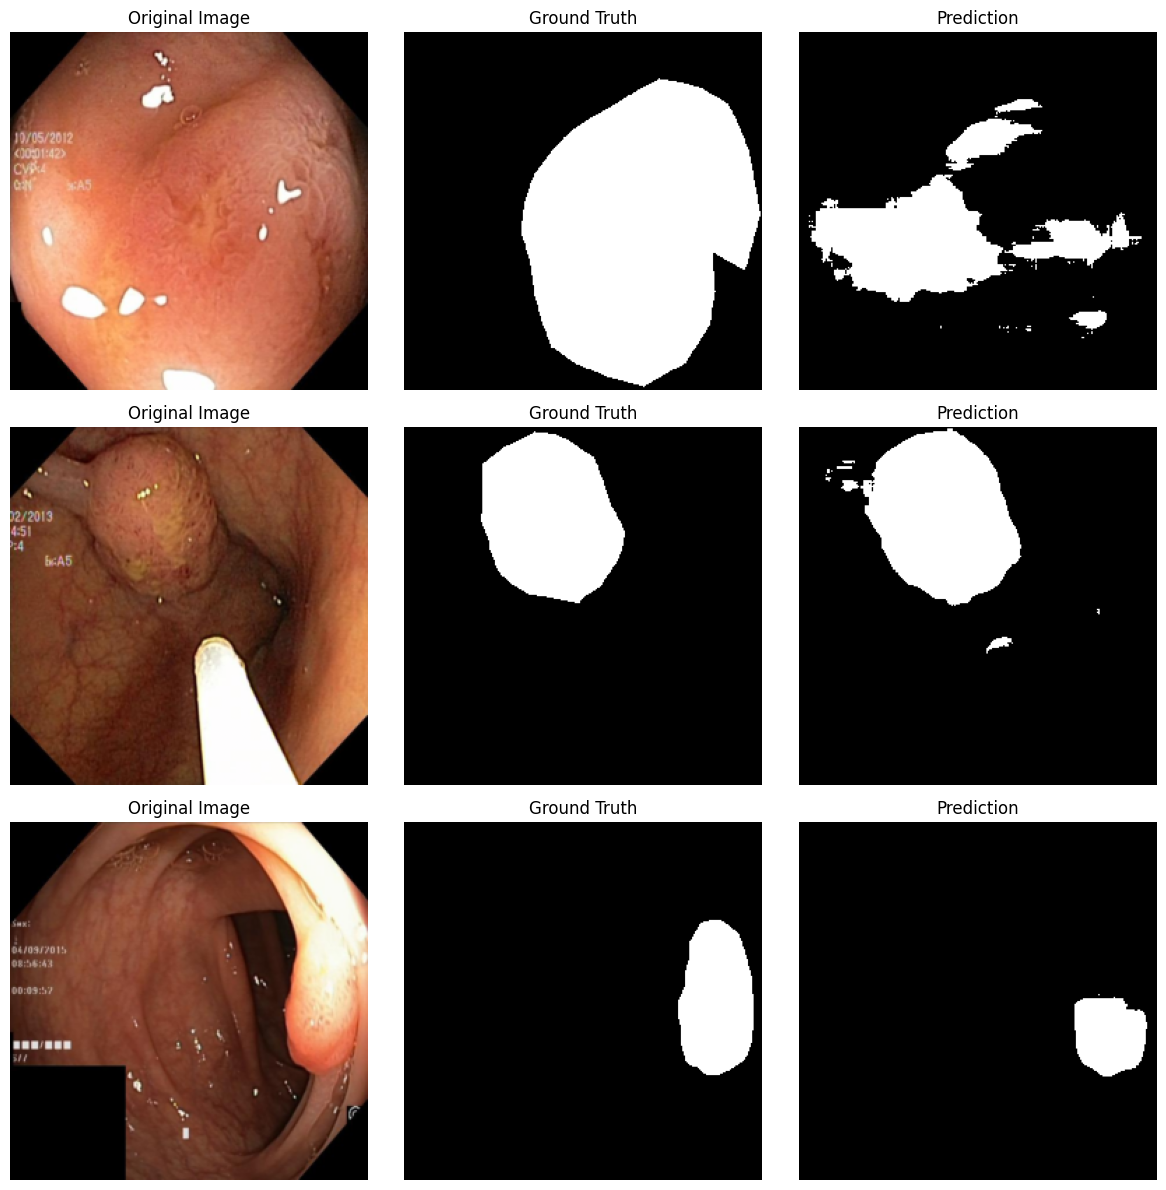

Training and evaluation completed!


In [4]:
# -------------------------
# Main Function - Adapted for Kaggle
# -------------------------
def main():
    print("Starting Mamba-UNet with Squeeze-Excitation Attention (No Feature Fusion)...")

    # Set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Set seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # Download and set up the dataset
    kvasir_path = download_and_setup_dataset(force_download=False)

    if not kvasir_path:
        print("Dataset setup failed. Exiting...")
        return

    # Define transformations
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    target_transform = T.Compose([
        T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
        T.ToTensor(),
        lambda x: (x > 0.5).long()
    ])

    # Create datasets and data loaders
    try:
        train_dataset = KvasirSEGDataset(
            kvasir_path,
            split='train',
            transform=transform,
            target_transform=target_transform,
            augment=True
        )

        val_dataset = KvasirSEGDataset(
            kvasir_path,
            split='val',
            transform=transform,
            target_transform=target_transform,
            augment=False
        )

        # Use batch size of 4 as requested
        train_loader = DataLoader(
            train_dataset,
            batch_size=4,
            shuffle=True,
            num_workers=2,
            pin_memory=True if torch.cuda.is_available() else False
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=4,
            shuffle=False,
            num_workers=2,
            pin_memory=True if torch.cuda.is_available() else False
        )

        print("Data loaders created successfully.")
    except Exception as e:
        print(f"Error creating datasets: {e}")
        import traceback
        traceback.print_exc()
        return

    # Initialize model args and create model with SE attention only (no feature fusion)
    args = ModelArgs()
    model = MambaUNetWithSE(args).to(device)
    print("Mamba-UNet model created with Squeeze-Excitation Attention only.")

    # Define enhanced loss function and optimizer
    criterion = DeepSupervisionLoss(main_weight=0.6, deep2_weight=0.2, deep3_weight=0.2)
    
    # Slightly lower learning rate for more stable training
    optimizer = torch.optim.AdamW(model.parameters(), lr=8e-5, weight_decay=1e-4)

    # Add learning rate scheduler with warm restarts
    scheduler = CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,  # Restart every 10 epochs
        T_mult=2,  # Double period after each restart
        eta_min=1e-6,
    )

    # Training loop
    num_epochs = 100
    best_iou = 0.0
    patience_counter = 0
    max_patience = 20  # Early stopping after 20 epochs without improvement

    history = {
        'train_loss': [], 'train_iou': [], 'train_dice': [],
        'val_loss': [], 'val_iou': [], 'val_dice': []
    }

    print(f"Starting training for {num_epochs} epochs...")

    try:
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")

            # Train with enhanced functions
            train_loss, train_iou, train_dice = train_one_epoch_enhanced(
                model, train_loader, optimizer, criterion, device, scheduler
            )

            # Validate
            val_loss, val_iou, val_dice = validate_enhanced(
                model, val_loader, criterion, device
            )

            # Save history
            history['train_loss'].append(train_loss)
            history['train_iou'].append(train_iou)
            history['train_dice'].append(train_dice)
            history['val_loss'].append(val_loss)
            history['val_iou'].append(val_iou)
            history['val_dice'].append(val_dice)

            # Print epoch results
            print(f"Train - Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f}")
            print(f"Val   - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}")

            # Save best model
            if val_iou > best_iou:
                best_iou = val_iou
                torch.save(model.state_dict(), "/kaggle/working/best_mamba_unet_with_se.pth")
                print(f"Model saved with IoU: {best_iou:.4f}")
                patience_counter = 0  # Reset patience counter
            else:
                patience_counter += 1

            # Save checkpoint every 10 epochs for safety
            if (epoch+1) % 10 == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'best_iou': best_iou,
                    'history': history,
                }, f"/kaggle/working/checkpoint_se_epoch_{epoch+1}.pth")

                # Plot and save training progress
                plot_training_progress(history, epoch+1)

            # Early stopping
            if patience_counter >= max_patience:
                print(f"Early stopping after {max_patience} epochs without improvement")
                break

            # Clear GPU cache between epochs
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error during training: {e}")
        import traceback
        traceback.print_exc()

        # Save checkpoint on error
        torch.save({
            'epoch': epoch if 'epoch' in locals() else 0,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if 'scheduler' in locals() else None,
            'best_iou': best_iou if 'best_iou' in locals() else 0,
            'history': history,
        }, "/kaggle/working/error_checkpoint_se.pth")

    # Load best model for evaluation
    try:
        model.load_state_dict(torch.load("/kaggle/working/best_mamba_unet_with_se.pth"))
        print("Loaded best model for evaluation")
    except:
        print("Could not load best model, using current model")

    # Visualize results
    visualize_results(model, val_loader, device)

    print("Training and evaluation completed!")

if __name__ == "__main__":
    main()